## Explore Exercises: Spark
### Corey Solitaire
`12.01.2020`

#### Imports

In [35]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## Exercises:

- Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

1. How many different cases are there, by department?

In [2]:
df.groupby("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



2. Does the percentage of cases that are late vary by department?

In [3]:
(
    df.groupBy("department")
    .pivot("case_late")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("department")
    .show(truncate=False)
)

+------------------------+------+------+
|department              |false |true  |
+------------------------+------+------+
|Animal Care Services    |0.25  |26.97 |
|City Council            |138.94|null  |
|Customer Service        |16.83 |134.21|
|DSD/Code Enforcement    |11.38 |98.71 |
|Metro Health            |4.87  |16.8  |
|Parks & Recreation      |5.9   |36.53 |
|Solid Waste             |2.11  |13.67 |
|Trans & Cap Improvements|7.82  |30.22 |
+------------------------+------+------+



In [4]:
(
    
    df.where(df.case_late == True)
    .groupBy("department")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("department")
    .show(truncate=False)
)

+------------------------+----------------------------+
|department              |round(avg(case_lifetime), 2)|
+------------------------+----------------------------+
|Animal Care Services    |26.97                       |
|Customer Service        |134.21                      |
|DSD/Code Enforcement    |98.71                       |
|Metro Health            |16.8                        |
|Parks & Recreation      |36.53                       |
|Solid Waste             |13.67                       |
|Trans & Cap Improvements|30.22                       |
+------------------------+----------------------------+



In [32]:
df.select('department', 'case_late').toPandas().groupby('department').case_late.mean().sort_values()

department
City Council                0.000000
Trans & Cap Improvements    0.056251
DSD/Code Enforcement        0.081634
Solid Waste                 0.117968
Metro Health                0.160566
Parks & Recreation          0.190737
Animal Care Services        0.199085
Customer Service            0.705511
Name: case_late, dtype: float64

In [75]:
(
    df.groupby('department')
      .pivot('case_late')
      .count()
      .select('department',
             round((col('true')/(col('true')+ col('false'))), 2).alias('percent_case_late'))
      .na.fill(0)
      .sort('department')
      .show(truncate =False)
)

+------------------------+-----------------+
|department              |percent_case_late|
+------------------------+-----------------+
|Animal Care Services    |0.2              |
|City Council            |0.0              |
|Customer Service        |0.71             |
|DSD/Code Enforcement    |0.08             |
|Metro Health            |0.16             |
|Parks & Recreation      |0.19             |
|Solid Waste             |0.12             |
|Trans & Cap Improvements|0.06             |
+------------------------+-----------------+



3. On average, how late are the late cases by department?

In [5]:
(
    df.where(df.case_late == True)
    .groupBy("department")
    .agg(round(mean("num_days_late"), 2)).withColumnRenamed("round(avg(num_days_late), 2)","avg_days_late")
    .orderBy("department")
    .show(truncate=False)
)

+------------------------+-------------+
|department              |avg_days_late|
+------------------------+-------------+
|Animal Care Services    |23.46        |
|Customer Service        |87.68        |
|DSD/Code Enforcement    |49.38        |
|Metro Health            |6.54         |
|Parks & Recreation      |22.35        |
|Solid Waste             |7.19         |
|Trans & Cap Improvements|10.6         |
+------------------------+-------------+



4. What is the service type that is the most late? Just for Parks & Rec?

In [6]:
(
    df.where(df.case_late == True)
    .groupBy('department',"service_request_type")
    .agg(round(mean("num_days_late"), 2)).withColumnRenamed("round(avg(num_days_late), 2)","avg_days_late")
    .orderBy(desc('avg_days_late'))
    .show(truncate=False)
)

+------------------------+----------------------------------------+-------------+
|department              |service_request_type                    |avg_days_late|
+------------------------+----------------------------------------+-------------+
|DSD/Code Enforcement    |Zoning: Recycle Yard                    |210.89       |
|DSD/Code Enforcement    |Zoning: Junk Yards                      |200.21       |
|DSD/Code Enforcement    |Structure/Housing Maintenance           |190.21       |
|DSD/Code Enforcement    |Donation Container Enforcement          |171.09       |
|DSD/Code Enforcement    |Storage of Used Mattress                |163.97       |
|DSD/Code Enforcement    |Labeling for Used Mattress              |162.43       |
|DSD/Code Enforcement    |Record Keeping of Used Mattresses       |154.0        |
|DSD/Code Enforcement    |Signage Requied for Sale of Used Mattr  |151.64       |
|Trans & Cap Improvements|Traffic Signal Graffiti                 |137.65       |
|DSD/Code Enforc

In [7]:
# Just parks and rec
(
    df.where(df.case_late == True)
    .groupBy('department',"service_request_type")
    .agg(round(mean("num_days_late"), 2)).withColumnRenamed("round(avg(num_days_late), 2)","avg_days_late")
    .orderBy(desc('avg_days_late'))
    .where(df.department == 'Parks & Recreation')
    .show(truncate=False)
)

+------------------+-------------------------------------+-------------+
|department        |service_request_type                 |avg_days_late|
+------------------+-------------------------------------+-------------+
|Parks & Recreation|Amenity Park Improvement             |76.87        |
|Parks & Recreation|Major Park Improvement Install       |75.79        |
|Parks & Recreation|Reservation Assistance               |66.03        |
|Parks & Recreation|Park Building Maint Invest           |59.37        |
|Parks & Recreation|Sportfield Lighting                  |51.48        |
|Parks & Recreation|Electrical                           |42.95        |
|Parks & Recreation|Tree Removal                         |40.28        |
|Parks & Recreation|Landscape Maintenance                |38.87        |
|Parks & Recreation|Heavy Equipment                      |38.57        |
|Parks & Recreation|Miscellaneous Park Equipment         |33.62        |
|Parks & Recreation|Tree Trimming/Maintenance      

5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [8]:
df.groupBy('department').count().show(truncate =False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |279270|
|Animal Care Services    |116915|
|Trans & Cap Improvements|96193 |
|Parks & Recreation      |19907 |
|Customer Service        |2849  |
|Metro Health            |5163  |
|City Council            |33    |
|DSD/Code Enforcement    |321374|
+------------------------+------+



In [9]:
# Solid Waste top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Solid Waste').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+-----------+---------------------+---------------+
|department |service_request_type |num_of_requests|
+-----------+---------------------+---------------+
|Solid Waste|No Pickup            |86855          |
|Solid Waste|Damaged Cart         |30338          |
|Solid Waste|Cart Exchange Request|22024          |
|Solid Waste|Lost/Stolen Cart     |18731          |
|Solid Waste|Dead Animal - Dog    |16714          |
+-----------+---------------------+---------------+
only showing top 5 rows



In [10]:
# Animal Care Services top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Animal Care Services').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+--------------------+-------------------------------+---------------+
|department          |service_request_type           |num_of_requests|
+--------------------+-------------------------------+---------------+
|Animal Care Services|Stray Animal                   |26760          |
|Animal Care Services|Aggressive Animal(Non-Critical)|24882          |
|Animal Care Services|Animal Neglect                 |13441          |
|Animal Care Services|Trapped/Confined Animal        |11354          |
|Animal Care Services|Public Nuisance(Own Animal)    |10715          |
+--------------------+-------------------------------+---------------+
only showing top 5 rows



In [11]:
#Trans & Cap Improvements top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Trans & Cap Improvements').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+------------------------+----------------------------------------------+---------------+
|department              |service_request_type                          |num_of_requests|
+------------------------+----------------------------------------------+---------------+
|Trans & Cap Improvements|Pot Hole Repair                               |20616          |
|Trans & Cap Improvements|Traffic Signal Ops and Maintenance - Emergency|7997           |
|Trans & Cap Improvements|Traffic Sign Missing/Down                     |5674           |
|Trans & Cap Improvements|Base/Pavement Repair                          |5385           |
|Trans & Cap Improvements|Signal Timing Modification                    |4414           |
+------------------------+----------------------------------------------+---------------+
only showing top 5 rows



In [12]:
# Parks & Recreation top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Parks & Recreation').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+------------------+----------------------------+---------------+
|department        |service_request_type        |num_of_requests|
+------------------+----------------------------+---------------+
|Parks & Recreation|Carpentry                   |1944           |
|Parks & Recreation|Plumbing                    |1782           |
|Parks & Recreation|Heating and Air Conditioning|1459           |
|Parks & Recreation|Playgrounds                 |1438           |
|Parks & Recreation|Ballfields                  |1234           |
+------------------+----------------------------+---------------+
only showing top 5 rows



In [13]:
# Customer Service top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Customer Service').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+----------------+--------------------+---------------+
|department      |service_request_type|num_of_requests|
+----------------+--------------------+---------------+
|Customer Service|Complaint           |2388           |
|Customer Service|Compliment          |461            |
+----------------+--------------------+---------------+



In [14]:
# Metro Health top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'Metro Health').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+------------+-----------------------+---------------+
|department  |service_request_type   |num_of_requests|
+------------+-----------------------+---------------+
|Metro Health|License Renewal Invoice|1349           |
|Metro Health|Hygienic Practices     |946            |
|Metro Health|Pests                  |715            |
|Metro Health|Food Contact Surfaces  |602            |
|Metro Health|Public Right of Way    |538            |
+------------+-----------------------+---------------+
only showing top 5 rows



In [15]:
# City Council top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'City Council').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+------------+--------------------------------------+---------------+
|department  |service_request_type                  |num_of_requests|
+------------+--------------------------------------+---------------+
|City Council|Request for Research/Information      |31             |
|City Council|CCO_Request for Research/Information_1|2              |
+------------+--------------------------------------+---------------+



In [16]:
# DSD/Code Enforcement top 5
(
    df.groupBy('department',"service_request_type")
    .agg(round(count("service_request_type"), 2))
    .where(df.department == 'DSD/Code Enforcement').withColumnRenamed("round(count(service_request_type), 2)","num_of_requests")
    .orderBy(desc('num_of_requests'))
    .show(5, truncate=False)
)

+--------------------+--------------------------------+---------------+
|department          |service_request_type            |num_of_requests|
+--------------------+--------------------------------+---------------+
|DSD/Code Enforcement|Overgrown Yard/Trash            |65895          |
|DSD/Code Enforcement|Bandit Signs                    |32910          |
|DSD/Code Enforcement|Front Or Side Yard Parking      |28794          |
|DSD/Code Enforcement|Junk Vehicle On Private Property|21473          |
|DSD/Code Enforcement|Alley-Way Maintenance           |20214          |
+--------------------+--------------------------------+---------------+
only showing top 5 rows



6. Does whether or not its a weekend matter for when a case is opened/closed?

In [17]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [18]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [19]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [20]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


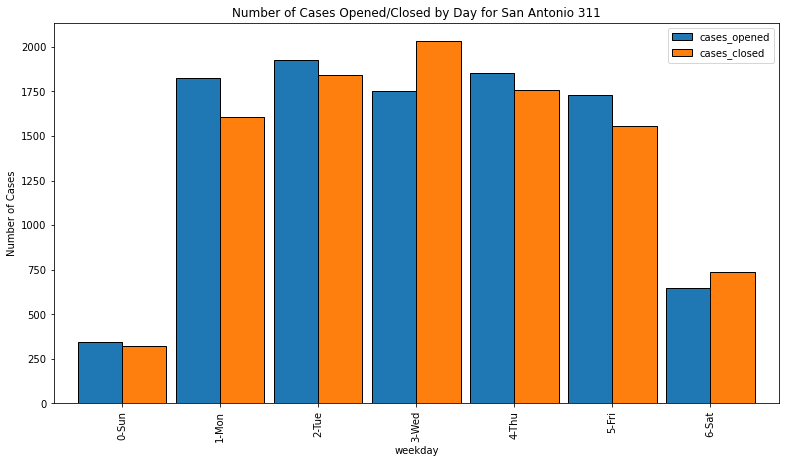

In [21]:
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.title('Number of Cases Opened/Closed by Day for San Antonio 311')
plt.ylabel('Number of Cases')
plt.show()

7. On average, how many cases are opened a day for the Customer Service department?

In [22]:
# Casses by day
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date")).where(df.department == 'Customer Service')

In [23]:
# Cases opened by day
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [24]:
#Cases closed by day
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [25]:
# Concat data frames
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

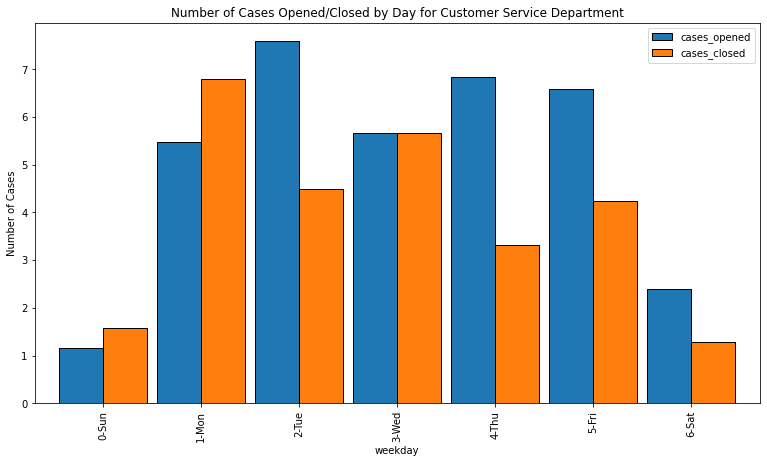

In [26]:
# Visualize
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.title('Number of Cases Opened/Closed by Day for Customer Service Department')
plt.ylabel('Number of Cases')
plt.show()

8. Does the number of service requests for the solid waste department vary by day of the week?

In [27]:
# Casses by day
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date")).where(df.department == 'Solid Waste')

In [28]:
# Cases opened by day
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [29]:
#Cases closed by day
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [30]:
# Concat data frames
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

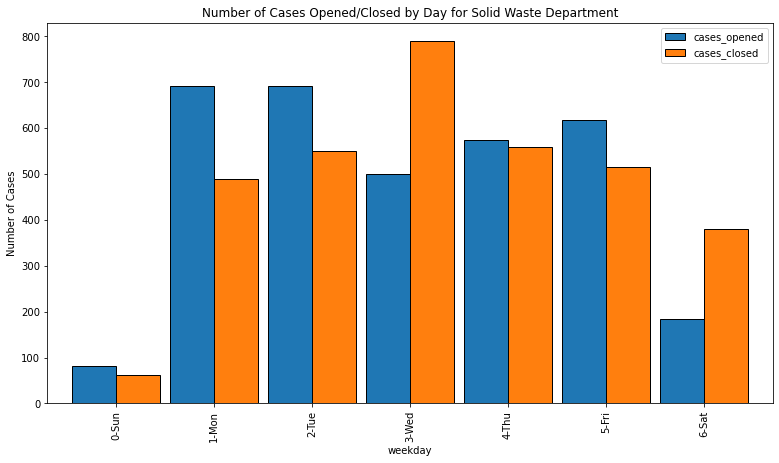

In [31]:
# Visualize
# Visualize
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.title('Number of Cases Opened/Closed by Day for Solid Waste Department')
plt.ylabel('Number of Cases')
plt.show()